In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Data

In [199]:
df_train = pd.read_csv("https://raw.githubusercontent.com/Zyttik-m/Car_price_prediction/refs/heads/main/data/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/Zyttik-m/Car_price_prediction/refs/heads/main/data/test.csv")
df_submission = pd.read_csv("https://raw.githubusercontent.com/Zyttik-m/Car_price_prediction/refs/heads/main/data/sample_submission.csv")

In [203]:
df_train

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000
...,...,...,...,...,...,...,...,...,...,...
1637,hyundai,2017,petrol,120000 miles,left,white,sedan,good,2.0,12400
1638,toyota,2014,petrol,170000 km,left,black,sedan,good,2.0,16500
1639,nissan,2018,petrol,68900 miles,left,blue,suv,good,2.0,19500
1640,nissan,2019,petrol,31000 miles,left,black,suv,excellent,2.0,19500


In [204]:
df_test

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,0,kia,2020,petrol,24000 km,left,black,sedan,excellent,2.0
1,1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
2,2,hyundai,2021,petrol,30000 miles,left,white,sedan,excellent,2.0
3,3,kia,2018,petrol,53000 miles,left,silver,sedan,excellent,2.0
4,4,mercedes-benz,2003,petrol,230000 km,left,black,Universal,normal,1.8
...,...,...,...,...,...,...,...,...,...,...
406,406,nissan,2021,petrol,33400 km,left,black,suv,excellent,2.0
407,407,hyundai,2017,petrol,60000 miles,left,other,sedan,excellent,2.0
408,408,mercedes-benz,2012,petrol,218000 km,left,white,sedan,good,2.0
409,409,kia,2020,petrol,40000 miles,left,red,sedan,good,2.0


In [206]:
df_submission

,Id,price
0,0,38
1,1,20549
2,2,3927
3,3,5572
4,4,28598
...,...,...
406,406,2514
407,407,20307
408,408,27274
409,409,14422


In [207]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB


In [208]:
df_train_copy = df_train.copy()

In [230]:
df_test_copy = df_test.copy()

# Data Cleaning

### Convert the year to the car age to better understand the data (base on year 2025)

In [209]:
df_train['car_age'] = 2025 - df_train['year']

### Convert miles to km

In [210]:
def convert_running_unit(data):
    if "km" in data:
        return float(data.replace("km", ""))
    else:
        return float(data.replace("miles", "")) * 1.609344 

df_train["running"] = df_train["running"].apply(convert_running_unit)

### Convert the categorical value in to numeric value

In [211]:
df_train = pd.get_dummies(df_train, columns=["model","motor_type","wheel","color","type"], drop_first=True)

In [213]:
df_train.iloc[:,6:36] = df_train.iloc[:,6:36].astype(bool).astype(float)

In [214]:
df_train["status"].unique()

array(['excellent', 'good', 'crashed', 'normal', 'new'], dtype=object)

In [215]:
df_train.groupby("status")["price"].median().sort_values(ascending=False)

status
new          23000.0
excellent    16450.0
crashed      13100.0
good         11450.0
normal        6000.0
Name: price, dtype: float64

In [216]:
custom_mapping = {
    'new': 5,  
    'excellent': 4,
    'crashed': 3,
    'good': 2,
    'normal': 1  
}

df_train["status_encoded"] = df_train["status"].map(custom_mapping)

In [217]:
df_train.drop("status", axis=1, inplace=True)

# Data Exploration

### How do we know that which feature is strongly affect to the price of th car? 

Find the correlation of all feature with price

In [218]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [219]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       1642 non-null   int64  
 1   running                    1642 non-null   float64
 2   motor_volume               1642 non-null   float64
 3   price                      1642 non-null   int64  
 4   car_age                    1642 non-null   int64  
 5   model_kia                  1642 non-null   float64
 6   model_mercedes-benz        1642 non-null   float64
 7   model_nissan               1642 non-null   float64
 8   model_toyota               1642 non-null   float64
 9   motor_type_gas             1642 non-null   float64
 10  motor_type_hybrid          1642 non-null   float64
 11  motor_type_petrol          1642 non-null   float64
 12  motor_type_petrol and gas  1642 non-null   float64
 13  color_black                1642 non-null   float

In [221]:
columns_to_scale = list(range(0,5)) + [35]
df_train.iloc[:,columns_to_scale]=scaler.fit_transform(df_train.iloc[:,columns_to_scale])

Use the correlation matrix to calculate how relate of the price  due to the other feature

In [222]:
correlation_matrix = df_train.corr()
correlation_with_price = correlation_matrix["price"].sort_values(ascending=False)

Plot the correlation matrix

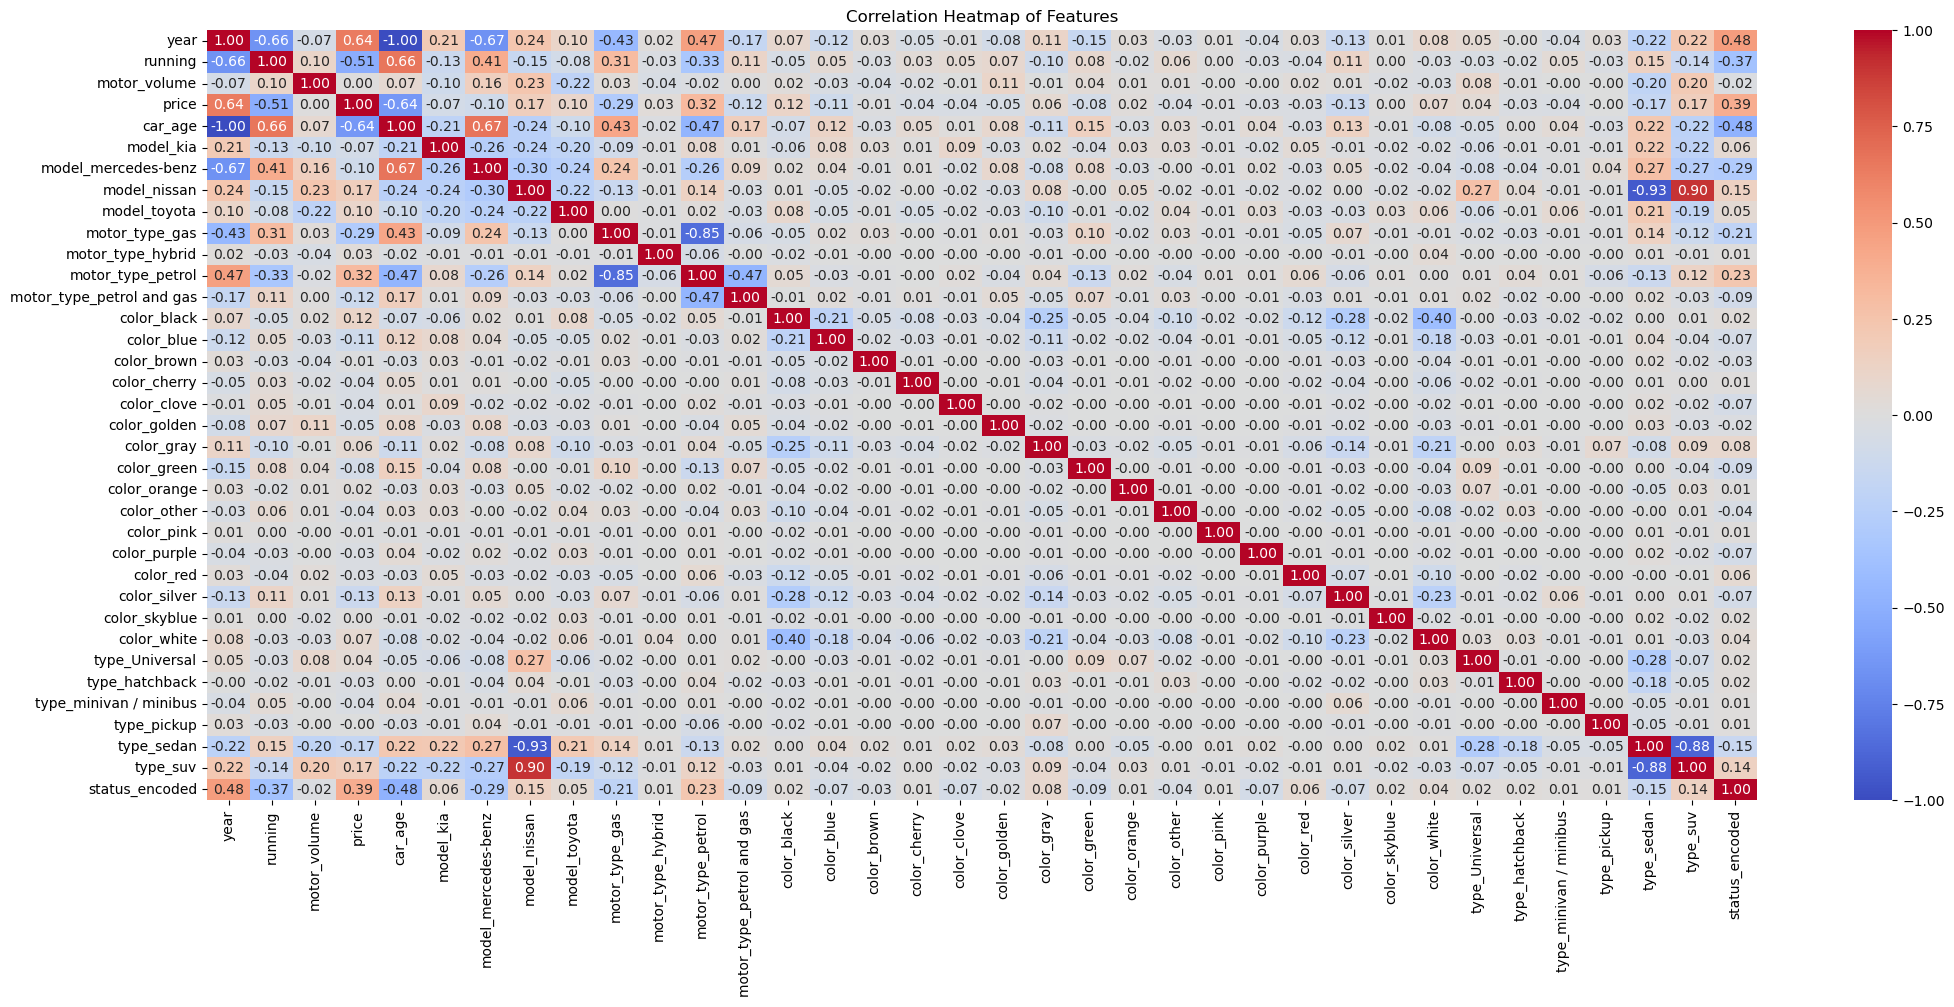

In [223]:
plt.figure(figsize=(25,10))
sns.heatmap(correlation_matrix, annot=True ,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

Plot only relate with price

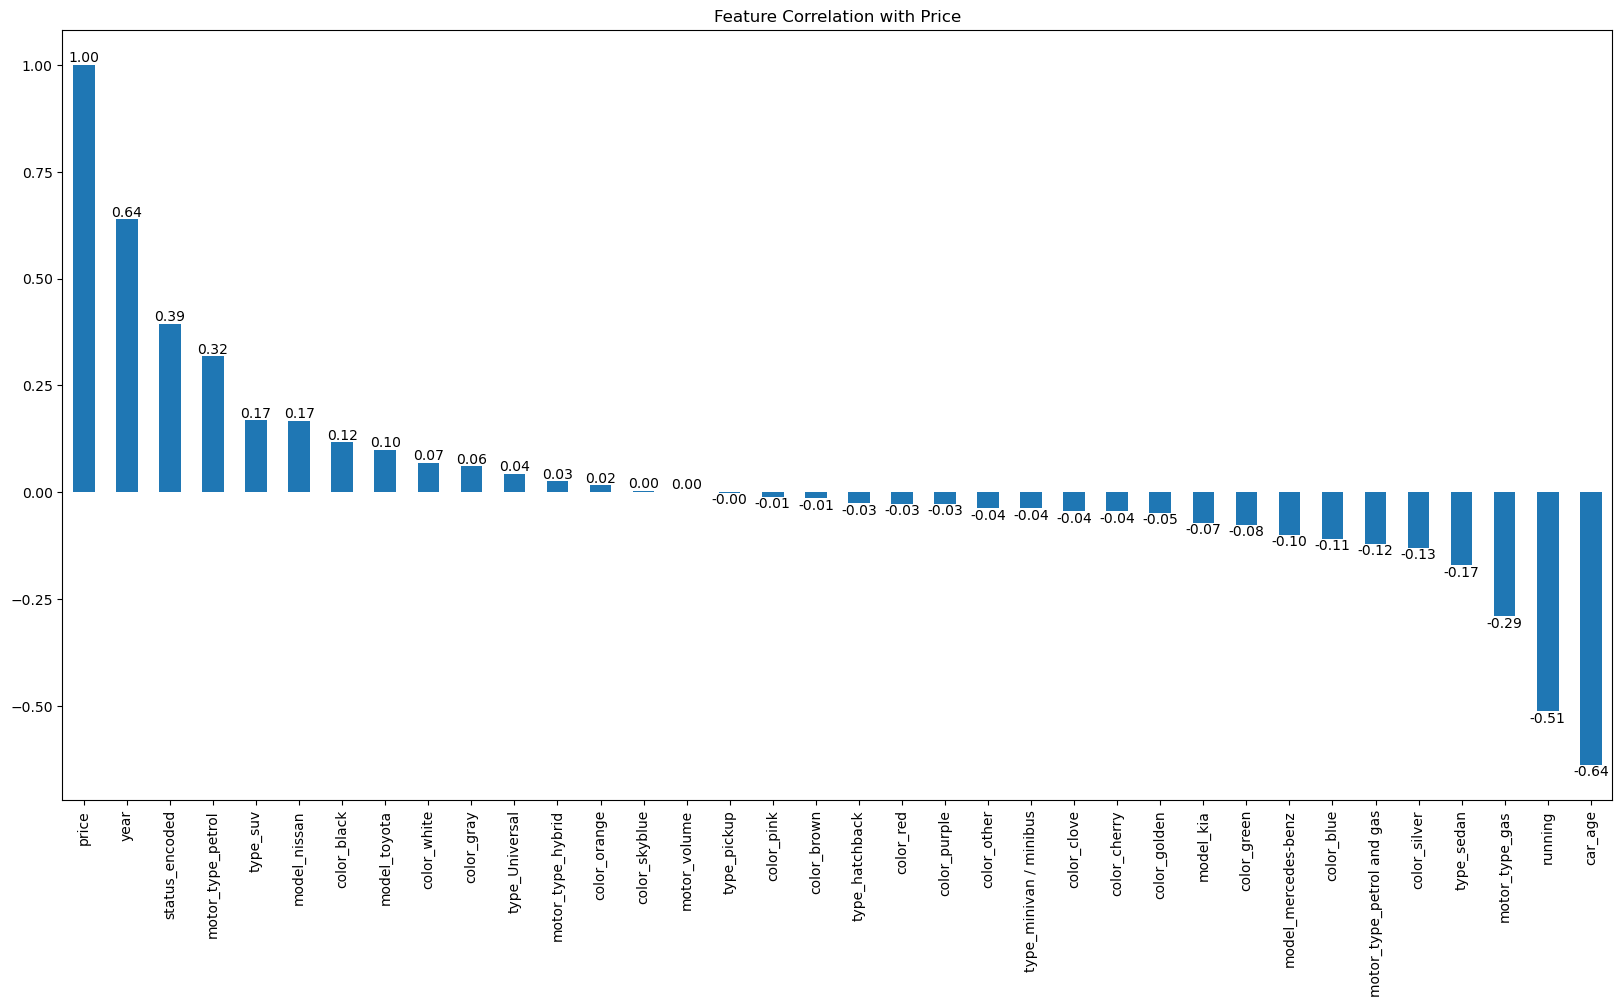

In [224]:
plt.figure(figsize=(20,10))
bar_graph = correlation_with_price.plot(kind="bar")
for bar in bar_graph.patches:
    value = bar.get_height()
    if value > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, value, f"{value:.2f}", ha="center", va="bottom", fontsize=10)
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, value, f"{value:.2f}", ha="center", va="top", fontsize=10)
plt.title("Feature Correlation with Price")
plt.show()

From the first correlation matrix we will see the feature that will make the redundancy to the machine learning. So we can drop some feature that is carry the same information.

1. year vs running
2. year vs car_age
3. model_nissan vs type_suv
4. model nissan vs type_sedan

We will see that feature `year` and `model nissan` is made a redundancy to the model so we should to drop it

----------------------------------------------------------------------------------------------------------------------------------------------------

From the second graph we will see the different between the feature that affect to the price, it will help us to drop some feature that is not affect to the price.  

1. motor_volume
2. type_pickup
3. color_skyblue


# Preprocessing Data

In [226]:
df_train.drop(["price","year","model_nissan","motor_volume","type_pickup","color_skyblue"],axis=1,inplace=True)

Preprocessing test data

In [229]:
df_train

,running,car_age,model_kia,model_mercedes-benz,model_toyota,motor_type_gas,motor_type_hybrid,motor_type_petrol,motor_type_petrol and gas,color_black,...,color_purple,color_red,color_silver,color_white,type_Universal,type_hatchback,type_minivan / minibus,type_sedan,type_suv,status_encoded
0,-1.201306,-1.092431,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547484
1,0.132209,0.122347,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547484
2,0.348131,-0.485042,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547484
3,1.046856,1.944514,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547484
4,0.111534,-0.333195,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.567735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,0.764039,-0.333195,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.567735
1638,0.525027,0.122347,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.567735
1639,-0.086076,-0.485042,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.567735
1640,-0.716592,-0.636889,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.547484


In [ ]:
df_test.drop("Id",axis=1,inplace=True)
df_test['car_age'] = 2025 - df_test['year']
df_test["running"] = df_test["running"].apply(convert_running_unit)
df_test = pd.get_dummies(df_test, columns=["model","motor_type","wheel","color","type"], drop_first=True)

In [236]:
df_test["status_encoded"] = df_test["status"].map(custom_mapping)
df_test.drop("status", axis=1, inplace=True)

In [240]:
df_test.iloc[:,4:28] = df_test.iloc[:,4:28].astype(bool).astype(float)

In [243]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       411 non-null    int64  
 1   running                    411 non-null    float64
 2   motor_volume               411 non-null    float64
 3   car_age                    411 non-null    int64  
 4   model_kia                  411 non-null    float64
 5   model_mercedes-benz        411 non-null    float64
 6   model_nissan               411 non-null    float64
 7   model_toyota               411 non-null    float64
 8   motor_type_petrol          411 non-null    float64
 9   motor_type_petrol and gas  411 non-null    float64
 10  wheel_right                411 non-null    float64
 11  color_black                411 non-null    float64
 12  color_blue                 411 non-null    float64
 13  color_brown                411 non-null    float64

In [246]:
columns_test_to_scale = list(range(0,4)) + [28]
df_test.iloc[:,columns_test_to_scale]=scaler.fit_transform(df_test.iloc[:,columns_test_to_scale])

In [249]:
df_test.drop(["year","model_nissan","motor_volume","color_skyblue"],axis=1,inplace=True)

In [253]:
df_test.drop("wheel_right",axis=1,inplace=True)

Match test and train dataset

In [255]:
train_columns = df_train.columns
for col in train_columns:
    if col not in df_test.columns:
        df_test[col] = 0
df_test = df_test[train_columns]

### Do the train-test-split

In [259]:
x_train = df_train
y_train = df_train_copy["price"]
x_test = df_test
y_test = df_submission["price"]

In [260]:
x_train

,running,car_age,model_kia,model_mercedes-benz,model_toyota,motor_type_gas,motor_type_hybrid,motor_type_petrol,motor_type_petrol and gas,color_black,...,color_purple,color_red,color_silver,color_white,type_Universal,type_hatchback,type_minivan / minibus,type_sedan,type_suv,status_encoded
0,-1.201306,-1.092431,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547484
1,0.132209,0.122347,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547484
2,0.348131,-0.485042,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547484
3,1.046856,1.944514,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547484
4,0.111534,-0.333195,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.567735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,0.764039,-0.333195,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.567735
1638,0.525027,0.122347,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.567735
1639,-0.086076,-0.485042,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.567735
1640,-0.716592,-0.636889,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.547484


In [261]:
x_test

,running,car_age,model_kia,model_mercedes-benz,model_toyota,motor_type_gas,motor_type_hybrid,motor_type_petrol,motor_type_petrol and gas,color_black,...,color_purple,color_red,color_silver,color_white,type_Universal,type_hatchback,type_minivan / minibus,type_sedan,type_suv,status_encoded
0,-1.065565,-0.771175,1.0,0.0,0.0,0,0,1.0,0.0,1.0,...,0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.529428
1,0.248562,-0.311823,0.0,0.0,0.0,0,0,1.0,0.0,0.0,...,0,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.529428
2,-0.782683,-0.924292,0.0,0.0,0.0,0,0,1.0,0.0,0.0,...,0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.529428
3,-0.351435,-0.464940,1.0,0.0,0.0,0,0,1.0,0.0,0.0,...,0,0.0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.529428
4,1.334471,1.831820,0.0,1.0,0.0,0,0,1.0,0.0,1.0,...,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,-2.718257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,-0.956049,-0.924292,0.0,0.0,0.0,0,0,1.0,0.0,1.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.529428
407,-0.220186,-0.311823,0.0,0.0,0.0,0,0,1.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.529428
408,1.194663,0.453764,0.0,1.0,0.0,0,0,1.0,0.0,0.0,...,0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,-1.635695
409,-0.595184,-0.771175,1.0,0.0,0.0,0,0,1.0,0.0,0.0,...,0,1.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-1.635695


In [262]:
y_train

0       24500
1       25500
2       11700
3       12000
4       26000
        ...  
1637    12400
1638    16500
1639    19500
1640    19500
1641    28500
Name: price, Length: 1642, dtype: int64

In [264]:
y_test

0         38
1      20549
2       3927
3       5572
4      28598
       ...  
406     2514
407    20307
408    27274
409    14422
410     9376
Name: price, Length: 411, dtype: int64

# Model Training

In [265]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Make the function to evaluate the model accuracy

In [290]:
def evaluate_model(model,x_train, y_train, x_test, y_test, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)  

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"Model: {model_name}")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.2f} ")
    print(f"MSE: {mse:.2f} ")
    print(f"RMSE: {rmse:.2f} ")


### Linear Regression

In [305]:
lr_model = LinearRegression()
evaluate_model(lr_model,x_train,y_train,x_test,y_test,"Linear Regression")

Model: Linear Regression
R² Score: -0.765
MAE: 9154.85 
MSE: 129514073.83 
RMSE: 11380.43 


### Decision Tree Regression

In [293]:
DT_model = DecisionTreeRegressor()
evaluate_model(DT_model,x_train,y_train,x_test,y_test,"Linear Regression")

Model: Linear Regression
R² Score: -0.925
MAE: 9224.67 
MSE: 141249250.49 
RMSE: 11884.83 


### KNN Regression

In [294]:
KNN_model = KNeighborsRegressor()
evaluate_model(KNN_model,x_train,y_train,x_test,y_test,"Linear Regression")

Model: Linear Regression
R² Score: -0.404
MAE: 8323.89 
MSE: 102977214.96 
RMSE: 10147.77 


### Random Forest Regression

In [295]:
RF_model = RandomForestRegressor()
evaluate_model(RF_model,x_train,y_train,x_test,y_test,"Linear Regression")

Model: Linear Regression
R² Score: -0.563
MAE: 8600.24 
MSE: 114651515.24 
RMSE: 10707.54 


### SVR

In [296]:
SVR_model = SVR()
evaluate_model(SVR_model,x_train,y_train,x_test,y_test,"Linear Regression")

Model: Linear Regression
R² Score: -0.007
MAE: 7428.89 
MSE: 73872525.26 
RMSE: 8594.91 


From all the result above we will see that it is worse than use to be so we will do the hyperparameter tuning for all these model.

# Hyperparameter Tuning

In [297]:
from sklearn.model_selection import GridSearchCV

In [298]:
param_grids = {
    "Linear Regression": {
        "model": [LinearRegression()],  
        "fit_intercept": [True, False],  
    },
    "Decision Tree": {
        "model": [DecisionTreeRegressor()],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "Random Forest": {
        "model": [RandomForestRegressor()],
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
    },
    "SVR": {
        "model": [SVR()],
        "kernel": ["linear", "rbf"],
        "C": [0.1, 1, 10],
        "gamma": [0.01, 0.1, 1],
    },
    "KNN": {
        "model": [KNeighborsRegressor()],
        "n_neighbors": [3, 5, 10, 20],
        "weights": ["uniform", "distance"],
    }
}

best_models = {}

for model_name, param in param_grids.items():
    print(f"🔍 Tuning {model_name}...")

    grid_search = GridSearchCV(
        estimator=param["model"][0],  
        param_grid={k: v for k, v in param.items() if k != "model"}, 
        cv=5,
        scoring="r2",
        n_jobs=-1
    )

    grid_search.fit(x_train, y_train)  

    best_models[model_name] = grid_search.best_estimator_

    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best R² Score: {grid_search.best_score_}\n")

🔍 Tuning Linear Regression...
Best Parameters for Linear Regression: {'fit_intercept': False}
Best R² Score: 0.652956299120265

🔍 Tuning Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best R² Score: 0.6704697143040277

🔍 Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best R² Score: 0.7394412188661634

🔍 Tuning SVR...
Best Parameters for SVR: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Best R² Score: 0.4131025422197789

🔍 Tuning KNN...
Best Parameters for KNN: {'n_neighbors': 10, 'weights': 'distance'}
Best R² Score: 0.667024643245272



Compare the result after doing the hyperparameter tuning

In [299]:
best_models

{'Linear Regression': LinearRegression(fit_intercept=False),
 'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10),
 'Random Forest': RandomForestRegressor(max_depth=10, min_samples_split=10),
 'SVR': SVR(C=10, gamma=0.01, kernel='linear'),
 'KNN': KNeighborsRegressor(n_neighbors=10, weights='distance')}

In [303]:
for model_name, best_model in best_models.items():
    #print(f"🔍 Evaluating {model_name}...")
    #print(best_model)
    evaluate_model(best_model, x_train, x_test, y_train, y_test, model_name)

ValueError: Found input variables with inconsistent numbers of samples: [1642, 411]